In [9]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [10]:
def benchmark(X, Y):
    return -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)


In [11]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [12]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [13]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 5, 5)
Y = np.random.uniform(-5, 5, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [14]:
df

x         y           z
0 -0.829780 -4.076614 -284.253932
1  2.203245 -3.137398 -111.669530
2 -4.998856 -1.544393 -247.301416
3 -1.976674 -1.032325 -128.722651
4 -3.532441  0.388167 -111.174208

In [15]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [16]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.32432971 -3.06924425]


In [17]:
df_sim = df.copy()

df_sim

x         y           z        a         b       sim_z      diff
0 -0.829780 -4.076614 -284.253932  4.32433 -3.069244 -282.256649 -1.997283
1  2.203245 -3.137398 -111.669530  4.32433 -3.069244 -113.354470  1.684940
2 -4.998856 -1.544393 -247.301416  4.32433 -3.069244 -242.011988 -5.289428
3 -1.976674 -1.032325 -128.722651  4.32433 -3.069244 -126.540507 -2.182144
4 -3.532441  0.388167 -111.174208  4.32433 -3.069244 -107.847611 -3.326597

In [18]:
df

x         y           z        a         b       sim_z      diff
0 -0.829780 -4.076614 -284.253932  4.32433 -3.069244 -282.256649 -1.997283
1  2.203245 -3.137398 -111.669530  4.32433 -3.069244 -113.354470  1.684940
2 -4.998856 -1.544393 -247.301416  4.32433 -3.069244 -242.011988 -5.289428
3 -1.976674 -1.032325 -128.722651  4.32433 -3.069244 -126.540507 -2.182144
4 -3.532441  0.388167 -111.174208  4.32433 -3.069244 -107.847611 -3.326597

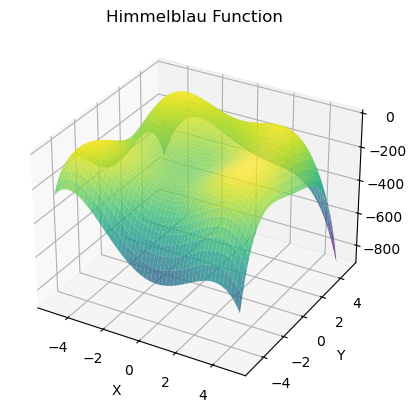

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Himmelblau Function')

# Show the plot
plt.show()

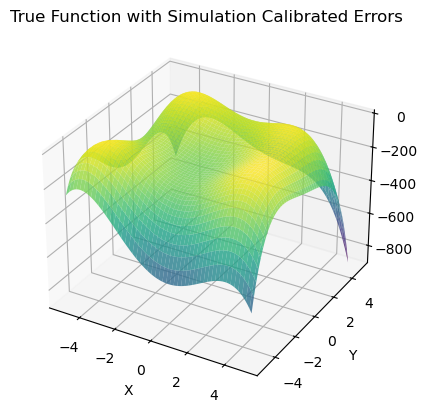

In [20]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [21]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [22]:
df_new = pd.DataFrame

In [23]:
def perform_iteration(df, df2):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-5, 5, 100)
    x2_range = np.linspace(-5, 5, 100)
    bounds = np.array([[-5, 5], [-5, 5]])  # Bounds for x1 and x2

    # Create a meshgrid and combine into a single array
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Calculate the Upper Confidence Level (UCL)
    ucl = pred_mean + 1.96 * pred_std

    # Locate the global maximum of the UCL
    max_index = np.argmax(ucl)
    global_max_point = x_grid[max_index]

    # Generate 9 additional points using Latin Hypercube Sampling (LHS) around the global maximum
    num_new_points = 9
    lhs_sampler = qmc.LatinHypercube(d=2)
    lhs_sample = lhs_sampler.random(num_new_points)

    # Scale LHS samples to a region around the global UCL maximum
    scaling_factor = 0.5  # Factor to control sampling range
    lhs_x1 = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) * (lhs_sample[:, 0] - 0.5)
    lhs_x2 = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) * (lhs_sample[:, 1] - 0.5)

    # Combine the LHS samples with the global maximum point
    new_points = np.c_[lhs_x1, lhs_x2]
    global_max_point = global_max_point.reshape(1, -1)  # Reshape to 2D for consistency
    all_points = np.vstack([new_points, global_max_point])  # Combine new points with the global max point

    # Clip the points to stay within the defined bounds
    all_points = np.clip(all_points, bounds[:, 0], bounds[:, 1])

    # Calculate UCL values for the newly sampled points
    new_mean, new_std = mc_dropout_predictions(best_model, all_points)
    new_ucl = new_mean + 1.96 * new_std  # Calculate the UCL for all sampled points

    # Store new sampled points and their UCL values in a DataFrame
    selected_points_df = pd.DataFrame(all_points, columns=['x', 'y'])
    df2 = selected_points_df.copy()
    selected_points_df['z'] = new_ucl

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot next candidate points
    ax.scatter(selected_points_df['x'], selected_points_df['y'], selected_points_df['z'], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    from matplotlib.patches import Rectangle

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x1_grid, x2_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Ensure global_max_point is 1D
    global_max_point = global_max_point.ravel()  # Flatten to a 1D array

    # Bounding box calculations
    scaling_factor = 0.5  # Scaling factor used earlier
    x1_min = global_max_point[0] - scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x1_max = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x2_min = global_max_point[1] - scaling_factor * (x2_range.max() - x2_range.min()) / 2
    x2_max = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) / 2

    # Draw the bounding box
    bbox = Rectangle((x1_min, x2_min), x1_max - x1_min, x2_max - x2_min,
                    edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
    plt.gca().add_patch(bbox)

    # Optionally overlay sampled points
    plt.scatter(all_points[:, 0], all_points[:, 1], color='white', edgecolor='black', label='Sampled Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response with Bounding Box")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    df2["z"] = benchmark(df2['x'], df2['y']) + ran_err(10, 0.05)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    df2["sim_z"] = sim_eval(df2["x"], df2["y"], df2["a"], df2["b"])
    df2["diff"] = df2["z"] - df2["sim_z"]

    df = pd.concat([df, df2], axis=0, ignore_index=True)

    # Select 5 candidate points for next physical observation
    df2_sorted = df2.sort_values(by='sim_z', ascending=False)
    df2 = df2_sorted.head(5)

    return df, df2


Best hyperparameters:
num_layers: 10
num_units: 113
learning_rate: 0.00593062085039305
dropout_rate: 0.18648286011554746
batch_size: 146
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 35749.3906
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 35658.5469
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 34869.0547
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 32462.5879
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 23505.5234
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5289.7852
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 104260.2578
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9391.8379
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11897.4453
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 17044.2676
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 25354.4531
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27301.2305
Epoch 13/200
1/1 ━━━━━━

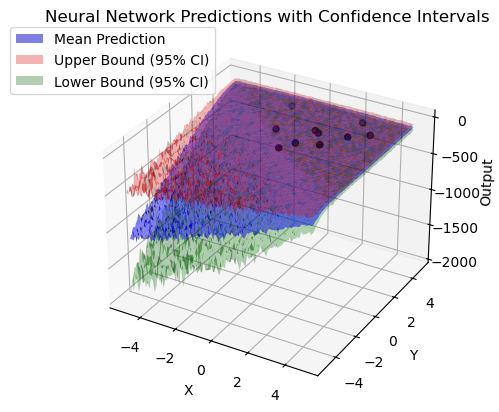

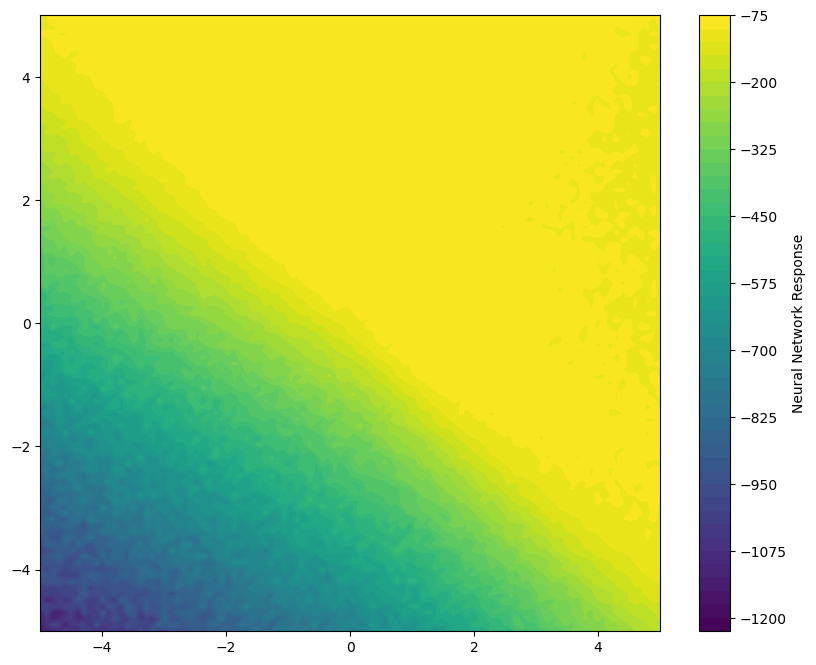

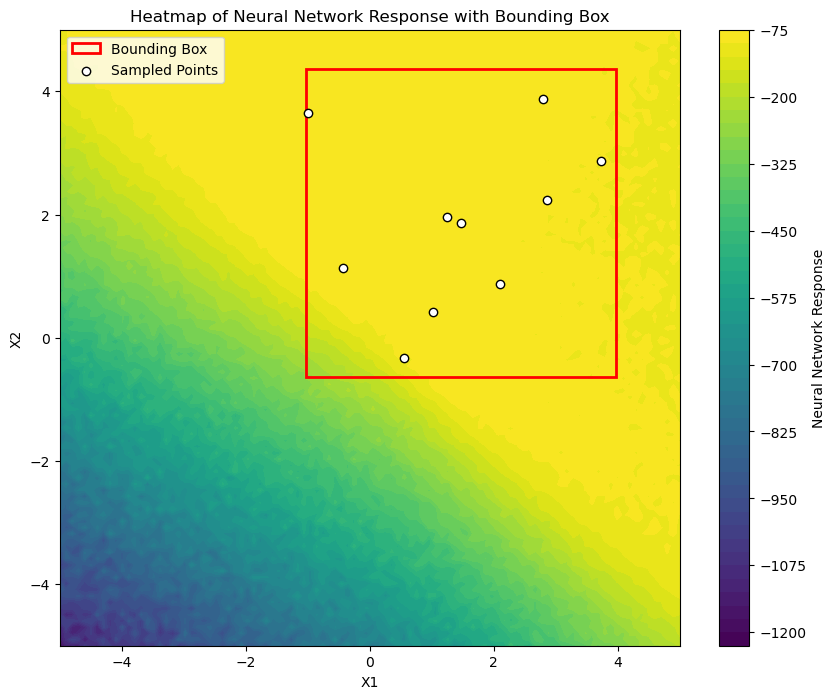

          x         y          z        a         b      sim_z      diff
2  2.856700  2.239525  -1.226465  4.32433 -3.069244  -0.846949 -0.379516
5  2.096969  0.865487 -50.183848  4.32433 -3.069244 -50.045209 -0.138639
9  1.464646  1.868687 -53.031325  4.32433 -3.069244 -52.857528 -0.173797
7  3.726145  2.876625 -58.164373  4.32433 -3.069244 -57.777798 -0.386575
1  1.250842  1.964079 -59.408319  4.32433 -3.069244 -59.291407 -0.116911
           x         y           z        a         b       sim_z      diff
0  -0.829780 -4.076614 -284.253932  4.32433 -3.069244 -282.256649 -1.997283
1   2.203245 -3.137398 -111.669530  4.32433 -3.069244 -113.354470  1.684940
2  -4.998856 -1.544393 -247.301416  4.32433 -3.069244 -242.011988 -5.289428
3  -1.976674 -1.032325 -128.722651  4.32433 -3.069244 -126.540507 -2.182144
4  -3.532441  0.388167 -111.174208  4.32433 -3.069244 -107.847611 -3.326597
5   1.027350  0.416337 -124.459134  4.32433 -3.069244 -124.367142 -0.091992
6   1.250842  1.964079  -59.40

In [24]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.002064401208013203
dropout_rate: 0.5
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step - loss: 17870.8145
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 17858.0273
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 17832.4062
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 17833.8574
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 17823.1953
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 17812.7461
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 17771.8418
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 17774.9004
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 17767.6992
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 17739.2285
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 17711.2324
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 17745.1660
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━

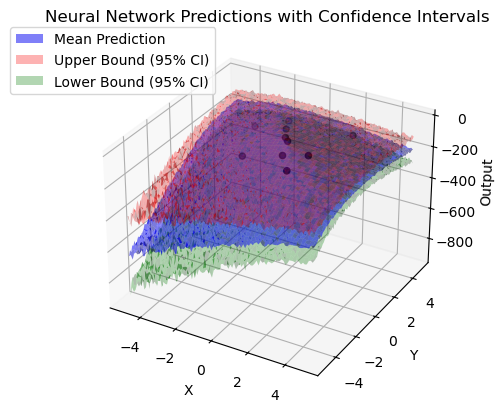

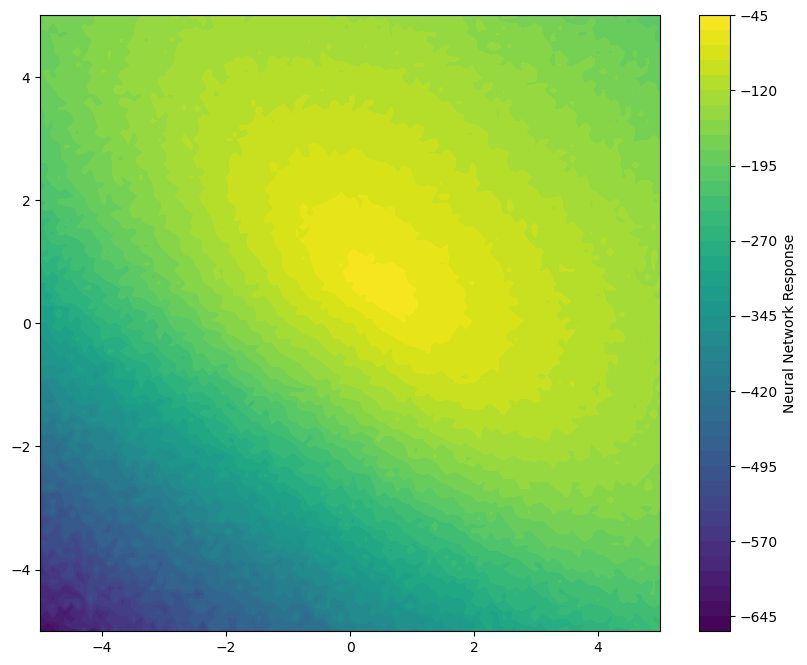

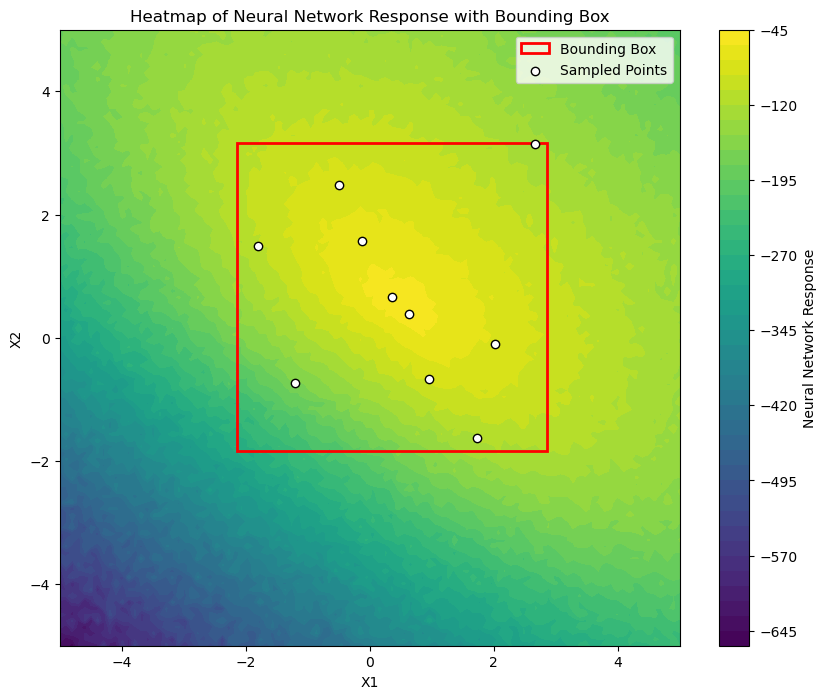

In [25]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 4
num_units: 50
learning_rate: 0.02103743770587188
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16895.6289
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16361.1963 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14228.6748 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9599.0869  
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2915.0100 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4877.3745 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2312.3372 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3412.5842 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3204.1418 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1765.1826 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2130.7078 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2395.0518 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

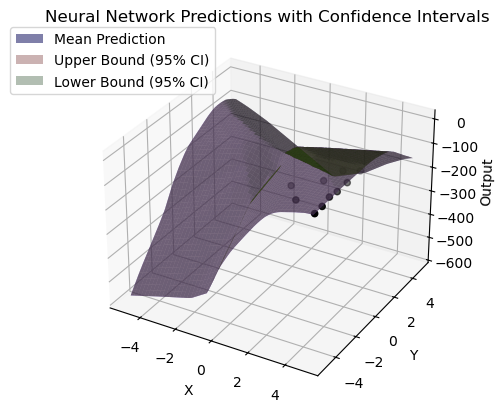

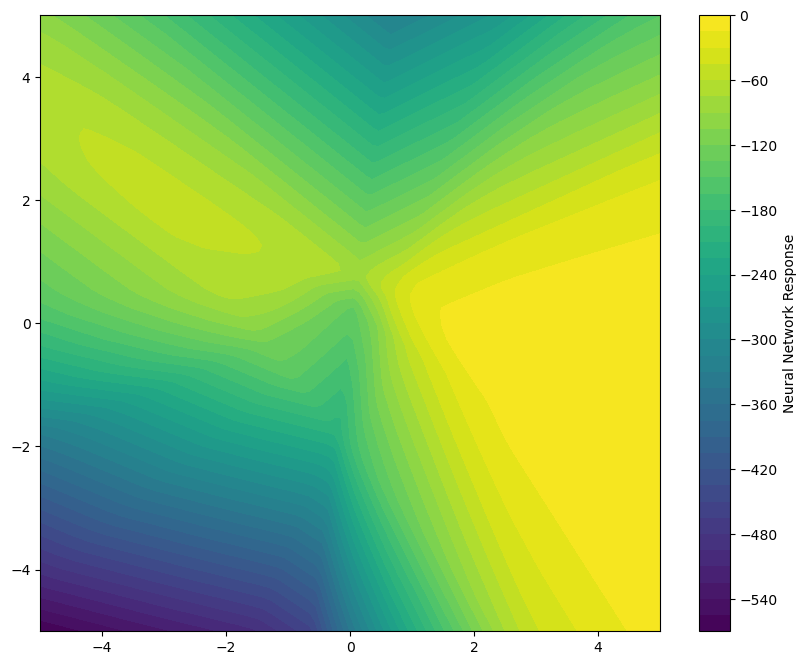

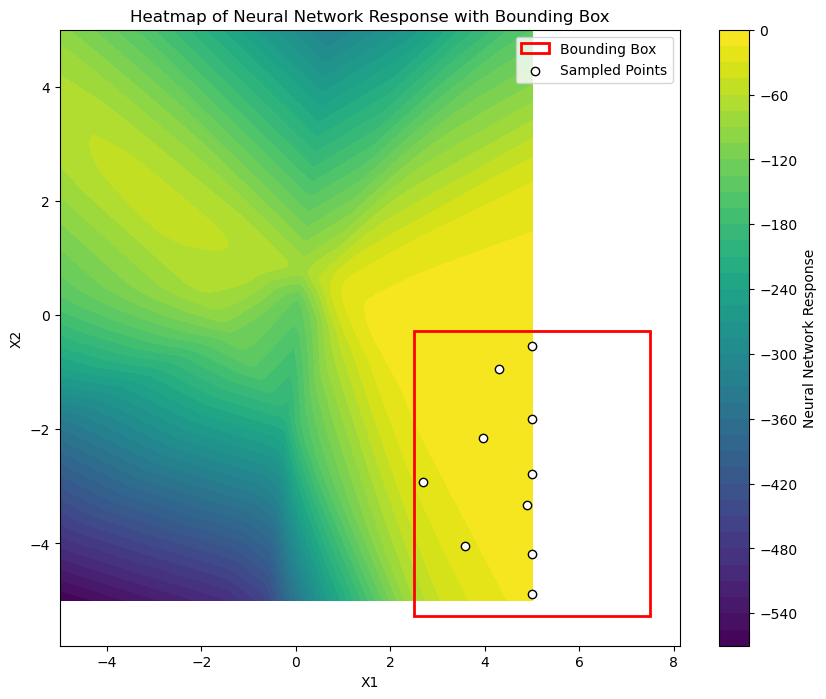

In [26]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 29787.7324 
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23582.3770 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12036.8311 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7763.5913 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4928.9155 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6762.9385 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6747.3823 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6079.0859 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5429.8774 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4649.5664 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6089.1226 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5868.4937 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5412.

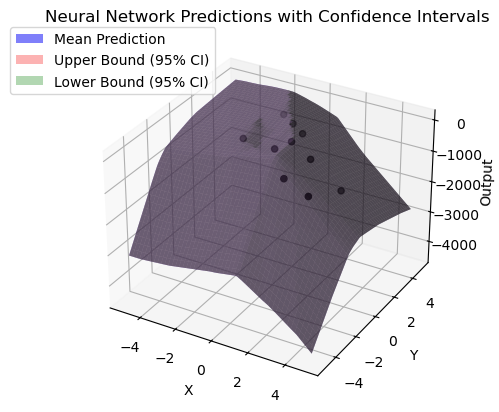

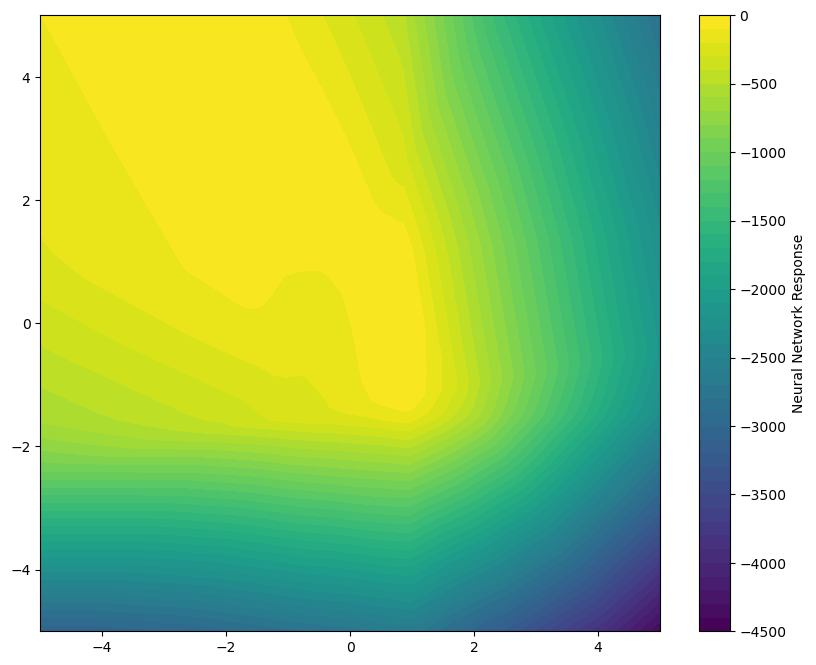

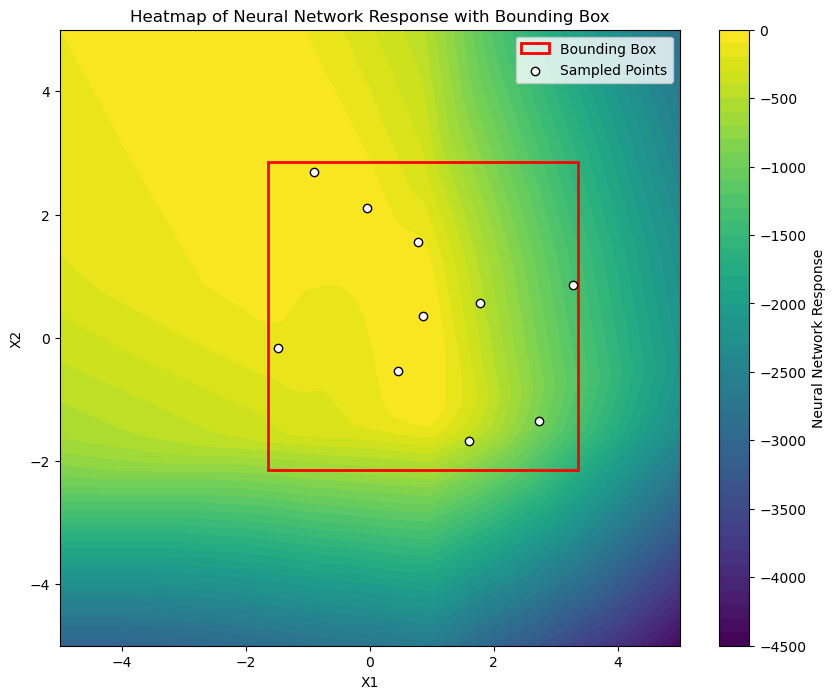

In [27]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 150
epochs: 155
Epoch 1/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step - loss: 24065.9980
Epoch 2/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 16712.8105
Epoch 3/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6848.5630
Epoch 4/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 12265.0059
Epoch 5/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5288.5059
Epoch 6/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9062.5000
Epoch 7/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9748.8477
Epoch 8/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7842.2974
Epoch 9/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5527.3232
Epoch 10/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6127.2505
Epoch 11/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7073.8301
Epoch 12/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5037.2217
Epoch 13/155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 46

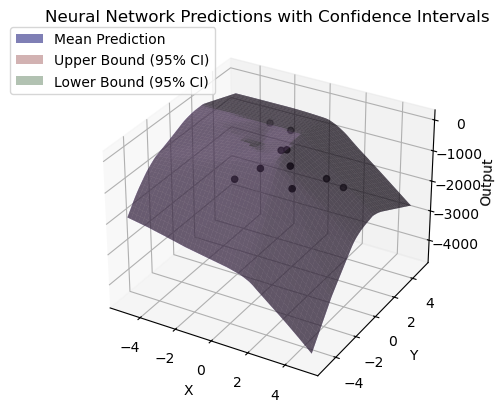

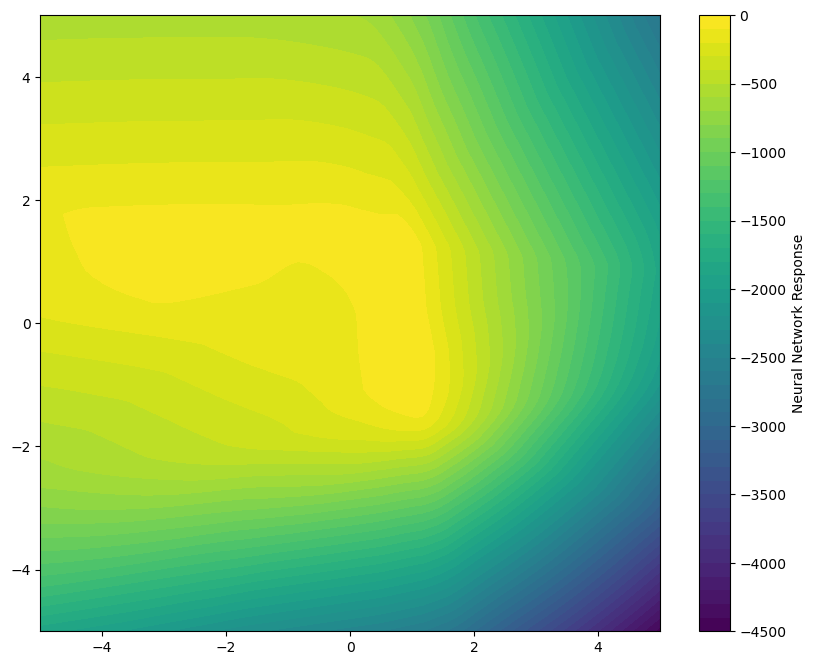

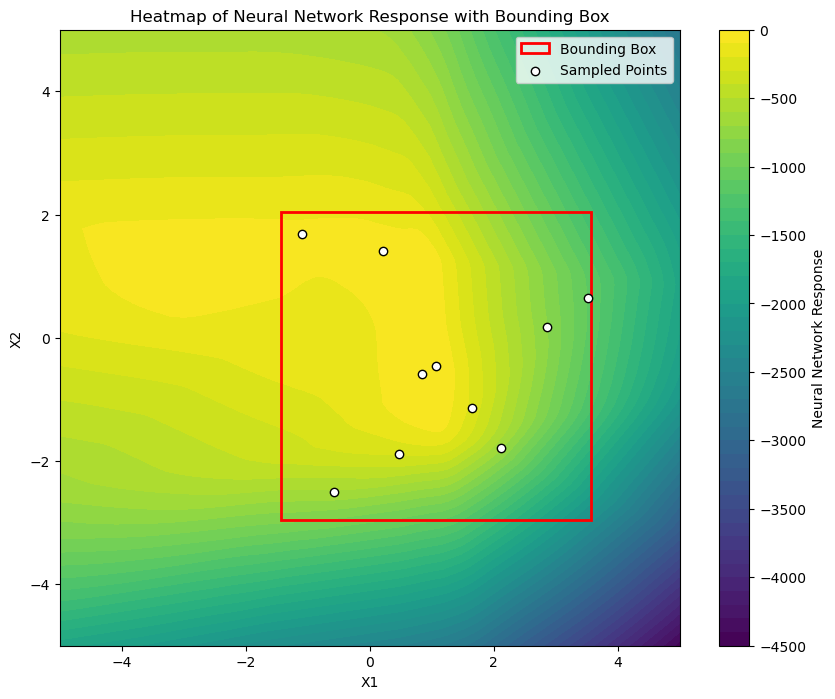

In [28]:
df_sim, df_new = perform_iteration(df_sim, df)


Best hyperparameters:
num_layers: 5
num_units: 200
learning_rate: 0.009184027138500084
dropout_rate: 0.0
batch_size: 150
epochs: 162
Epoch 1/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 22273.3848
Epoch 2/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 21947.1367
Epoch 3/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 20134.7656
Epoch 4/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 14333.3906
Epoch 5/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7092.6860
Epoch 6/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 19726.4863
Epoch 7/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5286.4067
Epoch 8/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7813.2676
Epoch 9/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10991.0137
Epoch 10/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12500.8984
Epoch 11/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 12615.6387
Epoch 12/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11561.1465
Epoch 13/162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

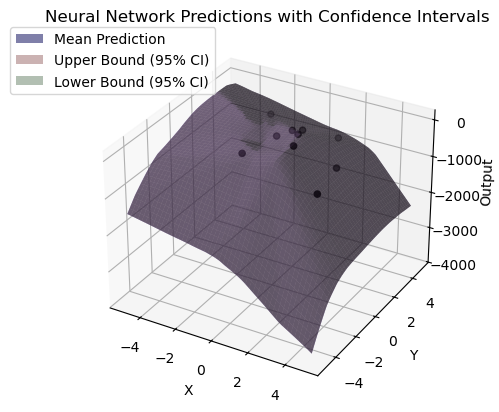

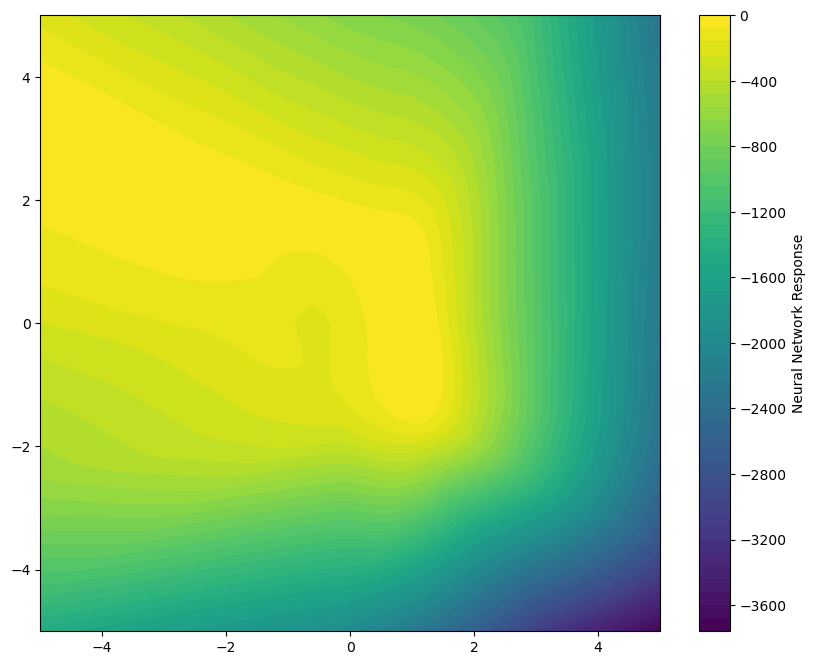

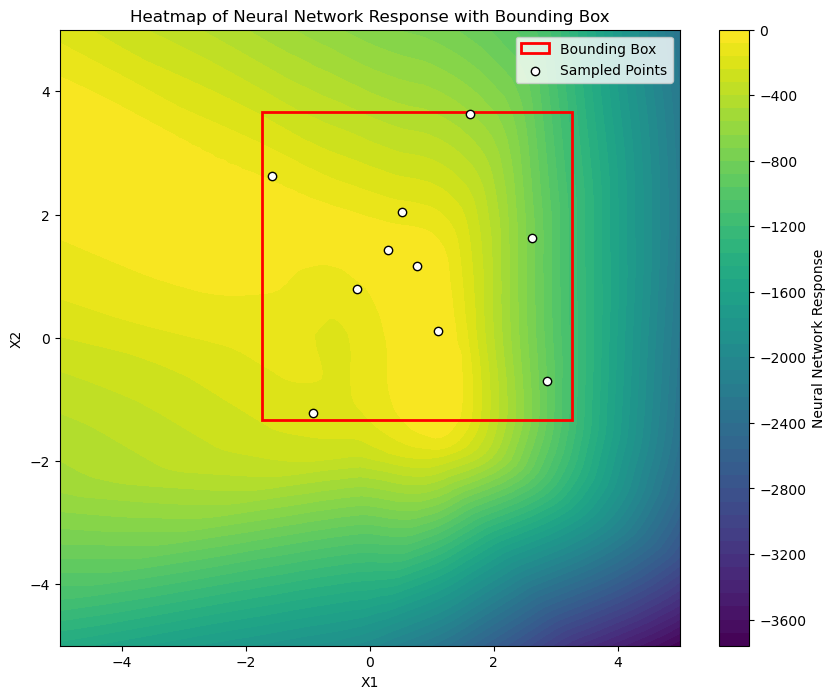

          x         y          z        a         b      sim_z      diff
7  2.611175  1.626250  -9.667875  4.32433 -3.069244  -9.381646 -0.286230
6  2.850583 -0.700151 -26.190022  4.32433 -3.069244 -26.146654 -0.043368
5 -1.575615  2.619001 -37.701627  4.32433 -3.069244 -37.948311  0.246684
1  0.514402  2.044204 -80.798778  4.32433 -3.069244 -80.836321  0.037543
2  1.619220  3.633085 -83.576676  4.32433 -3.069244 -83.473443 -0.103234
           x         y           z        a         b       sim_z      diff
0  -0.829780 -4.076614 -284.253932  4.32433 -3.069244 -282.256649 -1.997283
1   2.203245 -3.137398 -111.669530  4.32433 -3.069244 -113.354470  1.684940
2  -4.998856 -1.544393 -247.301416  4.32433 -3.069244 -242.011988 -5.289428
3  -1.976674 -1.032325 -128.722651  4.32433 -3.069244 -126.540507 -2.182144
4  -3.532441  0.388167 -111.174208  4.32433 -3.069244 -107.847611 -3.326597
..       ...       ...         ...      ...       ...         ...       ...
60 -1.575615  2.619001  -37.70

In [29]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 150
epochs: 105
Epoch 1/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step - loss: 20491.3828
Epoch 2/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 13636.2959
Epoch 3/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5288.3184
Epoch 4/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7490.6113
Epoch 5/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4645.1289
Epoch 6/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6763.5825
Epoch 7/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5892.0791
Epoch 8/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3802.3271
Epoch 9/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4779.7876
Epoch 10/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5003.5024
Epoch 11/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3475.4895
Epoch 12/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3981.3008
Epoch 13/105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 438

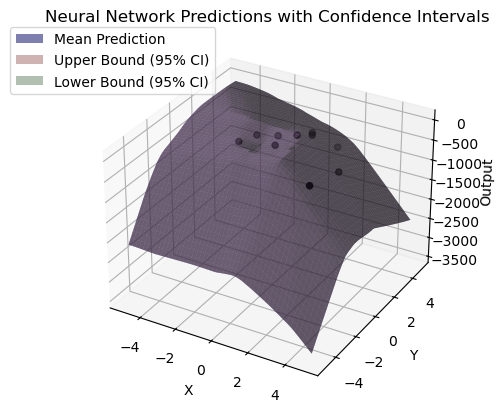

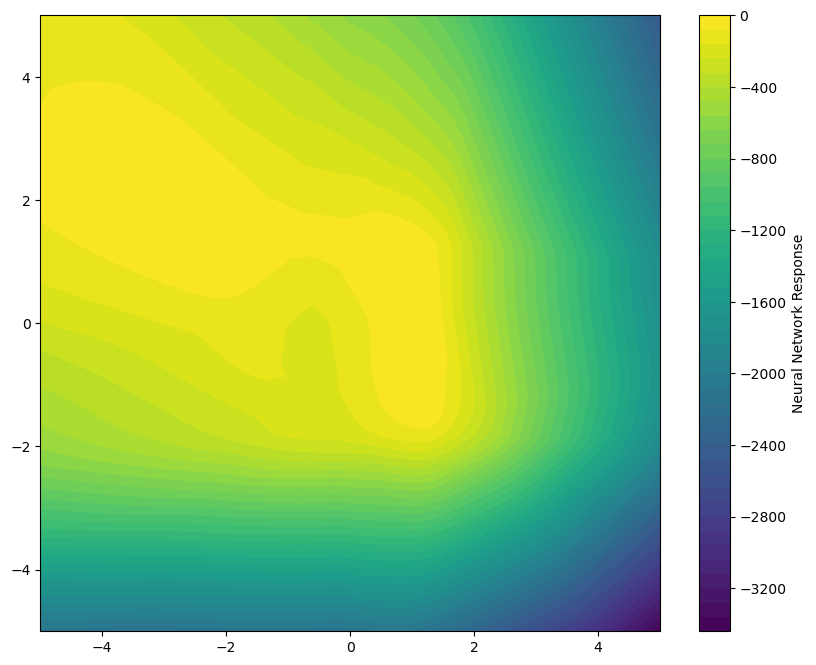

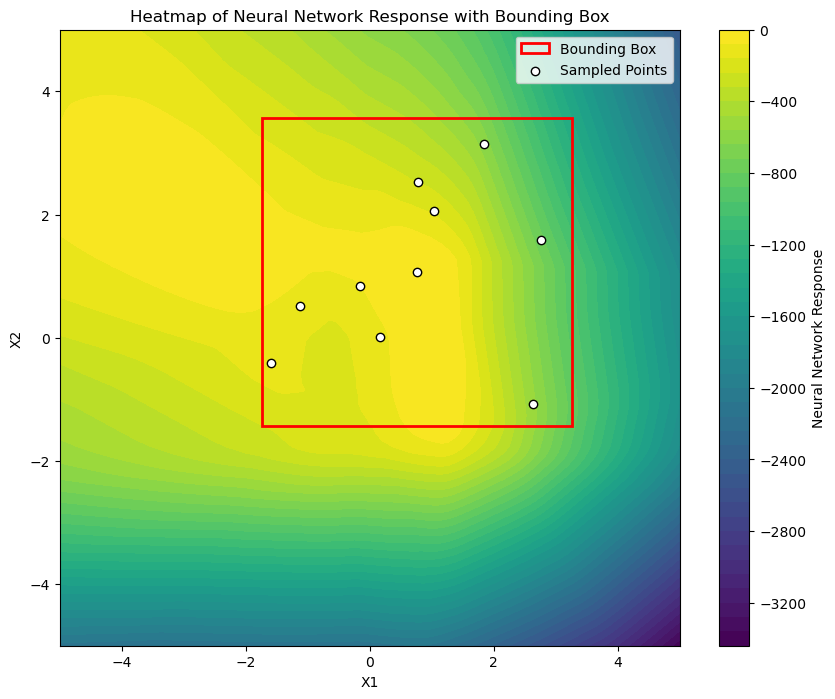

          x         y          z        a         b      sim_z      diff
4  2.756950  1.583523  -6.166477  4.32433 -3.069244  -6.094923 -0.071554
2  2.636728 -1.072043 -36.570571  4.32433 -3.069244 -36.542287 -0.028284
6  1.846814  3.145949 -42.199184  4.32433 -3.069244 -42.044809 -0.154375
0  0.782525  2.527269 -61.903957  4.32433 -3.069244 -61.749703 -0.154254
3  1.037271  2.054459 -64.988641  4.32433 -3.069244 -64.879964 -0.108677


In [30]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)

In [31]:
df_new

x         y          z        a         b      sim_z      diff
4  2.756950  1.583523  -6.166477  4.32433 -3.069244  -6.094923 -0.071554
2  2.636728 -1.072043 -36.570571  4.32433 -3.069244 -36.542287 -0.028284
6  1.846814  3.145949 -42.199184  4.32433 -3.069244 -42.044809 -0.154375
0  0.782525  2.527269 -61.903957  4.32433 -3.069244 -61.749703 -0.154254
3  1.037271  2.054459 -64.988641  4.32433 -3.069244 -64.879964 -0.108677

In [32]:
df

x         y           z        a         b       sim_z      diff
0 -0.829780 -4.076614 -284.253932  4.32433 -3.069244 -282.256649 -1.997283
1  2.203245 -3.137398 -111.669530  4.32433 -3.069244 -113.354470  1.684940
2 -4.998856 -1.544393 -247.301416  4.32433 -3.069244 -242.011988 -5.289428
3 -1.976674 -1.032325 -128.722651  4.32433 -3.069244 -126.540507 -2.182144
4 -3.532441  0.388167 -111.174208  4.32433 -3.069244 -107.847611 -3.326597

In [33]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -2.2221023229230723


In [34]:
df = pd.concat([df, df_new], ignore_index=True)
df

x         y           z        a         b       sim_z      diff
0 -0.829780 -4.076614 -284.253932  4.32433 -3.069244 -282.256649 -1.997283
1  2.203245 -3.137398 -111.669530  4.32433 -3.069244 -113.354470  1.684940
2 -4.998856 -1.544393 -247.301416  4.32433 -3.069244 -242.011988 -5.289428
3 -1.976674 -1.032325 -128.722651  4.32433 -3.069244 -126.540507 -2.182144
4 -3.532441  0.388167 -111.174208  4.32433 -3.069244 -107.847611 -3.326597
5  2.756950  1.583523   -6.166477  4.32433 -3.069244   -6.094923 -0.071554
6  2.636728 -1.072043  -36.570571  4.32433 -3.069244  -36.542287 -0.028284
7  1.846814  3.145949  -42.199184  4.32433 -3.069244  -42.044809 -0.154375
8  0.782525  2.527269  -61.903957  4.32433 -3.069244  -61.749703 -0.154254
9  1.037271  2.054459  -64.988641  4.32433 -3.069244  -64.879964 -0.108677

In [35]:
df = df.iloc[:, :-4]
df

x         y           z
0 -0.829780 -4.076614 -284.253932
1  2.203245 -3.137398 -111.669530
2 -4.998856 -1.544393 -247.301416
3 -1.976674 -1.032325 -128.722651
4 -3.532441  0.388167 -111.174208
5  2.756950  1.583523   -6.166477
6  2.636728 -1.072043  -36.570571
7  1.846814  3.145949  -42.199184
8  0.782525  2.527269  -61.903957
9  1.037271  2.054459  -64.988641

In [36]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)



[ 4.25839654 -3.10980452]


In [37]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 3.0, "Y": 2.0, "Z": benchmark(3.0, 2.0)},
    {"X": -2.805, "Y": 3.131, "Z": benchmark(-2.805, 3.131)},
    {"X": -3.779, "Y": -3.283, "Z": benchmark(-3.779, -3.283)},
    {"X": 3.584, "Y": -1.848, "Z": benchmark(3.584, -1.848)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X      Y         Z
0  3.000  2.000 -0.000000
1 -2.805  3.131 -0.000004
2 -3.779 -3.283 -0.000005
3  3.584 -1.848 -0.000009

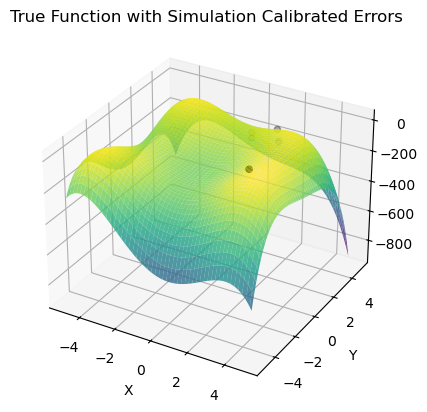

In [38]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new["x"], df_new["y"], df_new["sim_z"], color='black', marker='o', label='Next Sampling Points')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)



# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [39]:
df

x         y           z         a         b       sim_z      diff
0 -0.829780 -4.076614 -284.253932  4.258397 -3.109805 -284.189317 -0.064615
1  2.203245 -3.137398 -111.669530  4.258397 -3.109805 -111.883375  0.213845
2 -4.998856 -1.544393 -247.301416  4.258397 -3.109805 -246.968163 -0.333254
3 -1.976674 -1.032325 -128.722651  4.258397 -3.109805 -128.486903 -0.235748
4 -3.532441  0.388167 -111.174208  4.258397 -3.109805 -111.231325  0.057117
5  2.756950  1.583523   -6.166477  4.258397 -3.109805   -6.185117  0.018641
6  2.636728 -1.072043  -36.570571  4.258397 -3.109805  -36.626082  0.055512
7  1.846814  3.145949  -42.199184  4.258397 -3.109805  -42.101377 -0.097808
8  0.782525  2.527269  -61.903957  4.258397 -3.109805  -61.756762 -0.147195
9  1.037271  2.054459  -64.988641  4.258397 -3.109805  -64.896353 -0.092288

In [40]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -0.06257929721635964


In [41]:
# New DataFrame with the first 5 data points
df_original = df.iloc[:5]

print(df_original)

          x         y           z         a         b       sim_z      diff
0 -0.829780 -4.076614 -284.253932  4.258397 -3.109805 -284.189317 -0.064615
1  2.203245 -3.137398 -111.669530  4.258397 -3.109805 -111.883375  0.213845
2 -4.998856 -1.544393 -247.301416  4.258397 -3.109805 -246.968163 -0.333254
3 -1.976674 -1.032325 -128.722651  4.258397 -3.109805 -128.486903 -0.235748
4 -3.532441  0.388167 -111.174208  4.258397 -3.109805 -111.231325  0.057117


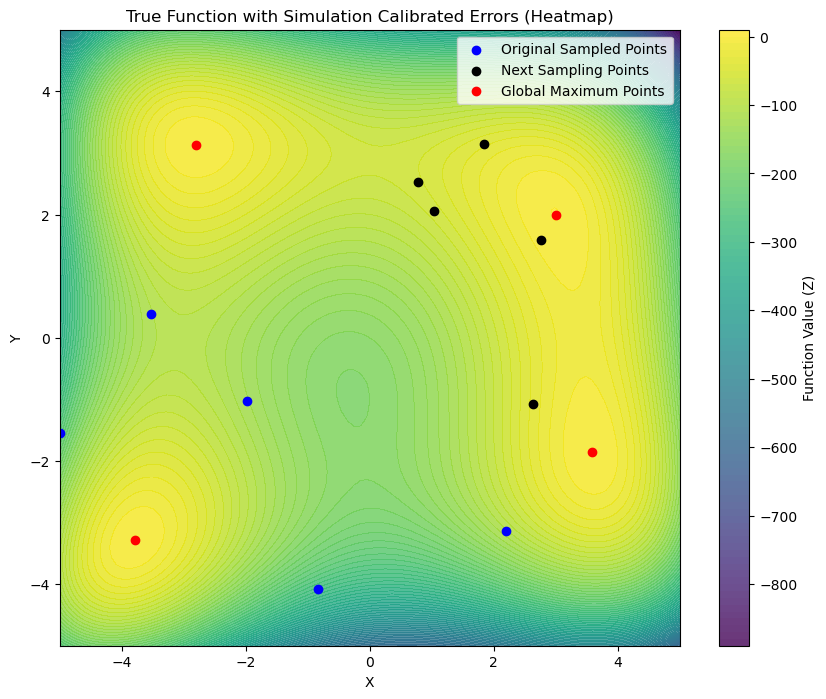

In [42]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [43]:
df_new2 = pd.DataFrame

df_sim = df.copy()

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.018709436265268636
dropout_rate: 0.0
batch_size: 150
epochs: 166
Epoch 1/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step - loss: 19409.9297
Epoch 2/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 18804.1719
Epoch 3/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 17794.1719
Epoch 4/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 16170.0439
Epoch 5/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 13857.1904
Epoch 6/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 10906.3135
Epoch 7/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7585.0210
Epoch 8/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4395.4058
Epoch 9/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2162.8875
Epoch 10/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2227.8899
Epoch 11/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4188.4824
Epoch 12/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4717.3994
Epoch 13/166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

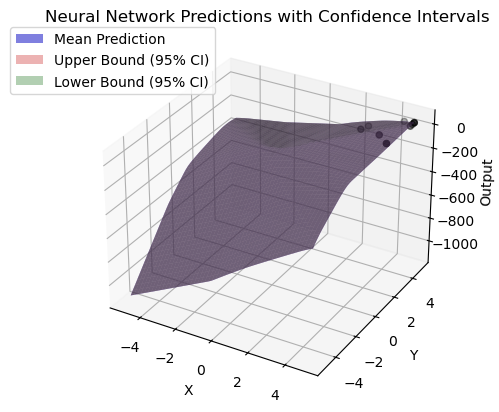

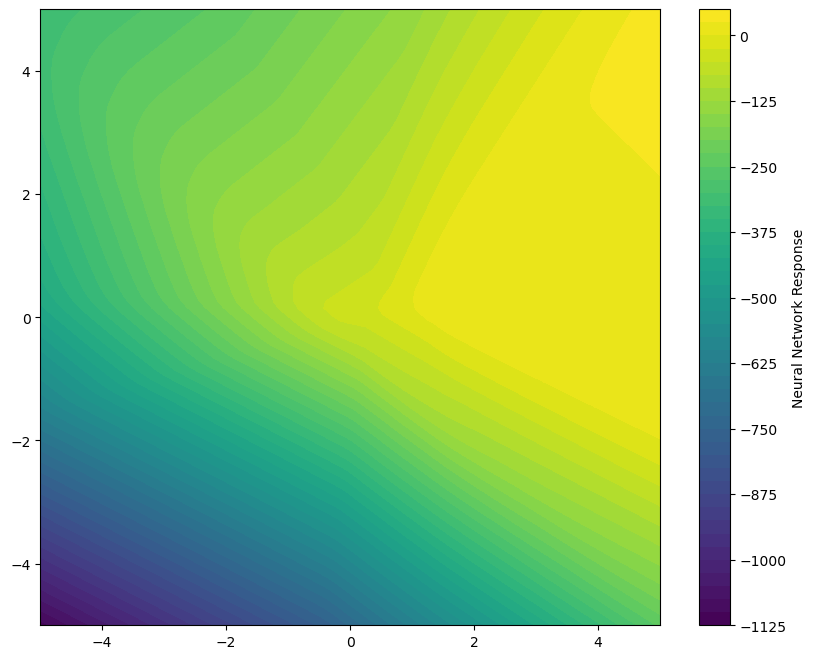

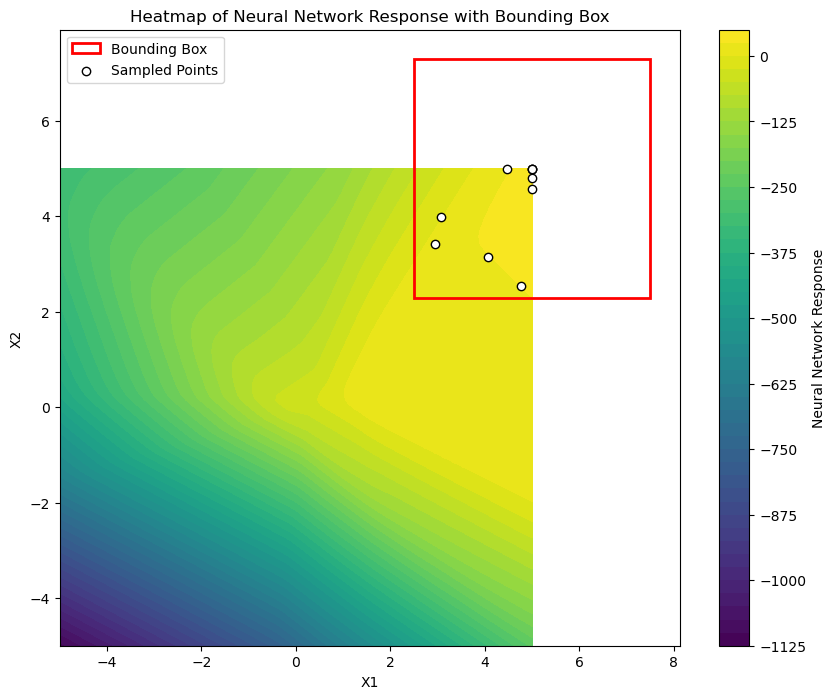

In [44]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 147
learning_rate: 0.04653036730968689
dropout_rate: 0.0
batch_size: 72
epochs: 197
Epoch 1/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step - loss: 213451.6250
Epoch 2/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 209496.9062
Epoch 3/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 199690.7500
Epoch 4/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 181066.3125
Epoch 5/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 153956.6250
Epoch 6/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 123633.0391
Epoch 7/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 85091.1641
Epoch 8/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 47327.6328
Epoch 9/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 34912.2930
Epoch 10/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 61373.6875
Epoch 11/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 71076.2188
Epoch 12/197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 56018.3008
Epoch 13/197
1/1 ━━━━━━━━━━━━━━

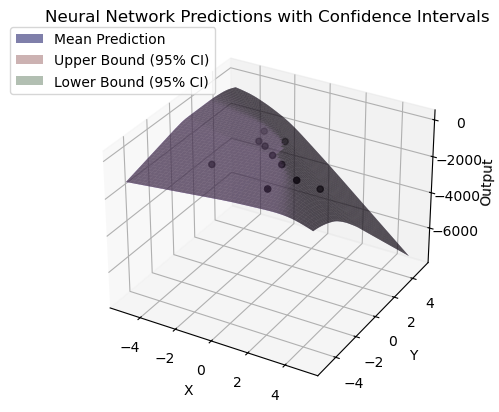

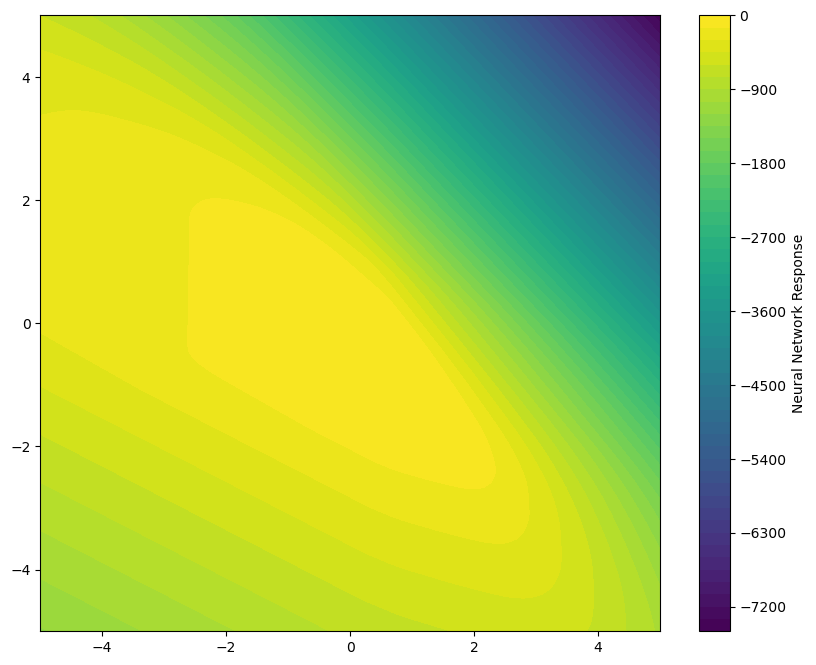

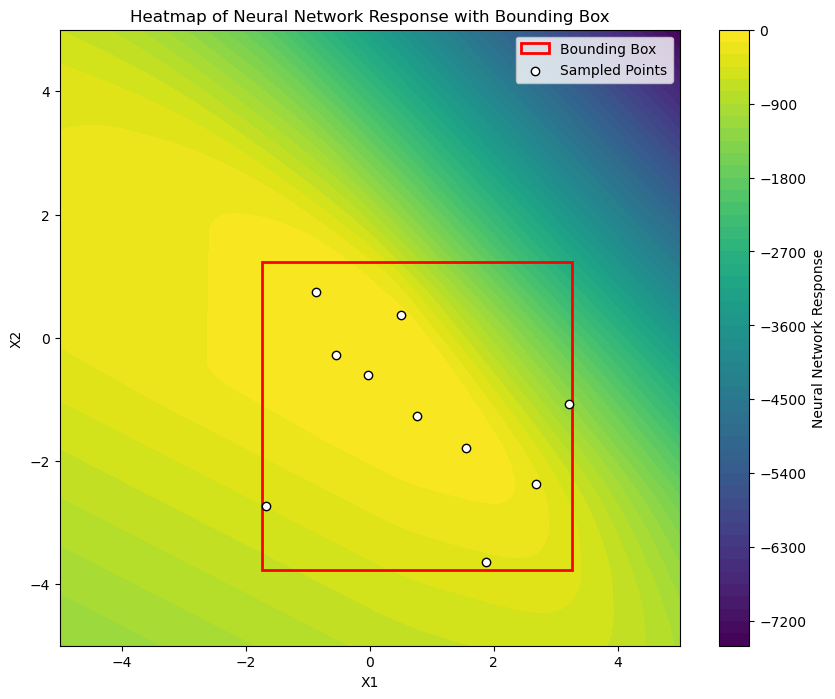

In [45]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 143653.5938  
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27584.8711 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 208032.0469 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36188.9453 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72758.6484 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81555.8672 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 74138.5078 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48698.2383 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25000.5312 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43795.4531 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29171.5293 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20192.6133 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

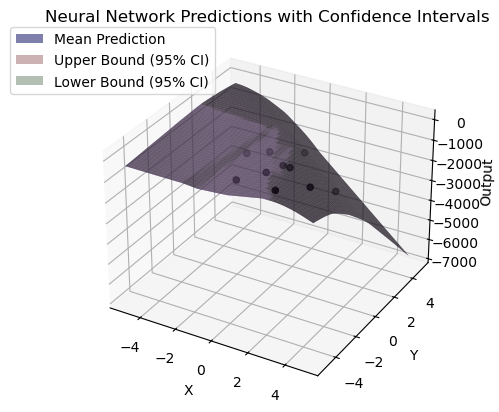

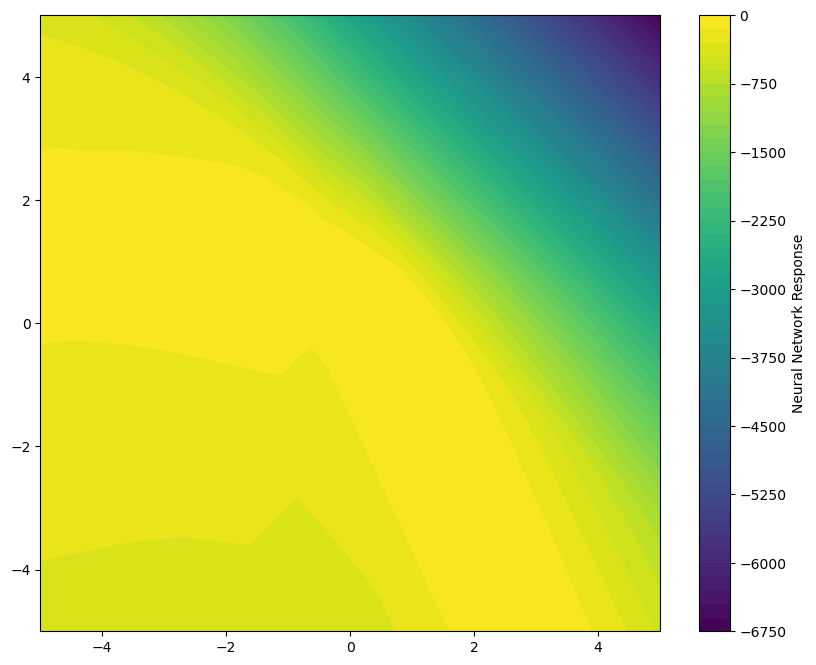

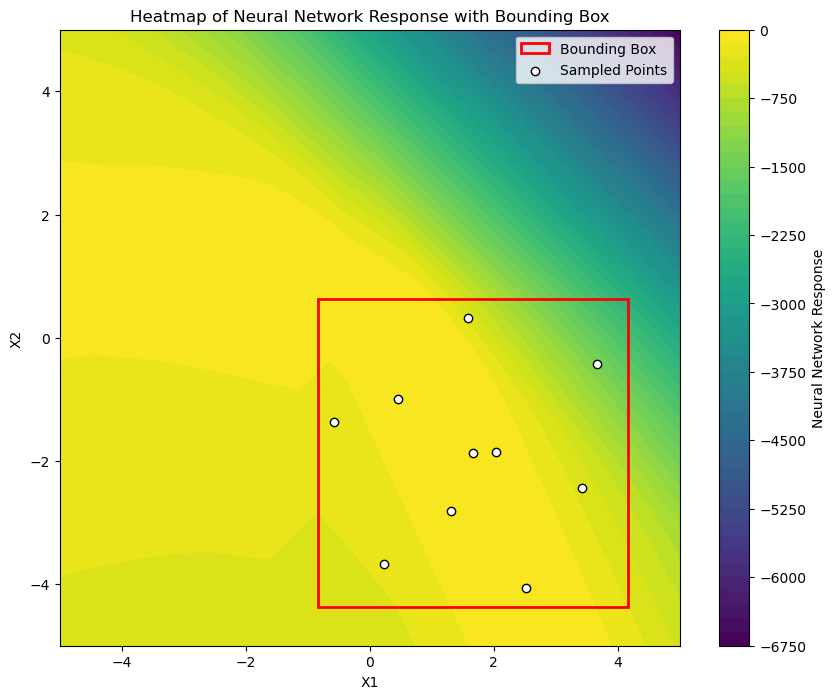

In [46]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.04857810325544147
dropout_rate: 0.22241284342900142
batch_size: 45
epochs: 186
Epoch 1/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step - loss: 117345.4531
Epoch 2/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 113076.1719
Epoch 3/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 100974.2734
Epoch 4/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 77856.2031
Epoch 5/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 48345.3398
Epoch 6/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 31555.0684
Epoch 7/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 40325.4414
Epoch 8/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 44994.6445
Epoch 9/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 30765.6934
Epoch 10/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27063.2969
Epoch 11/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 22543.3848
Epoch 12/186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 29831.9805
Epoch 13/186
1/1 ━

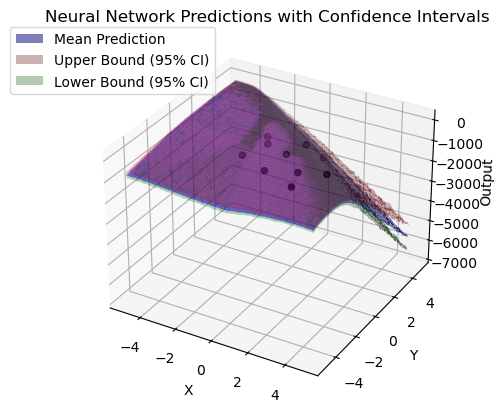

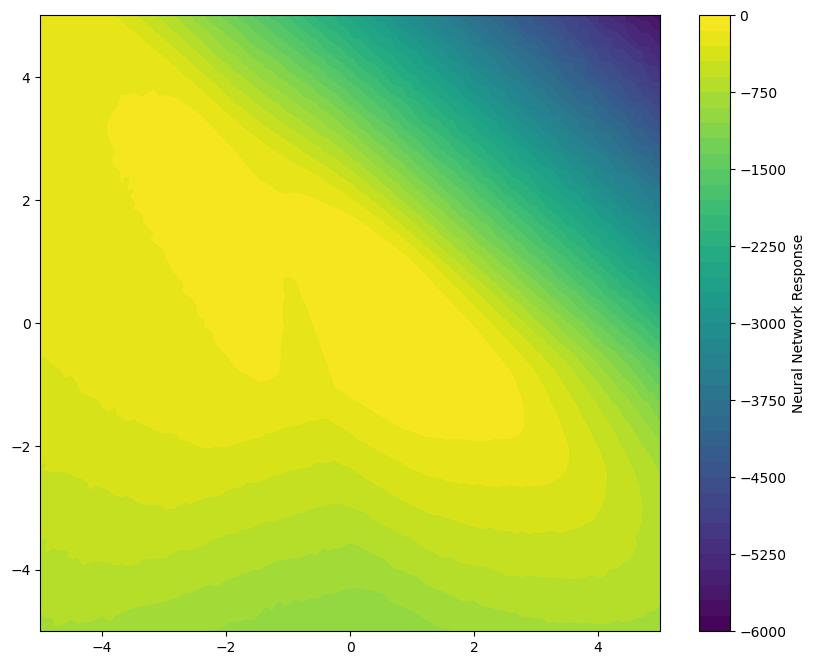

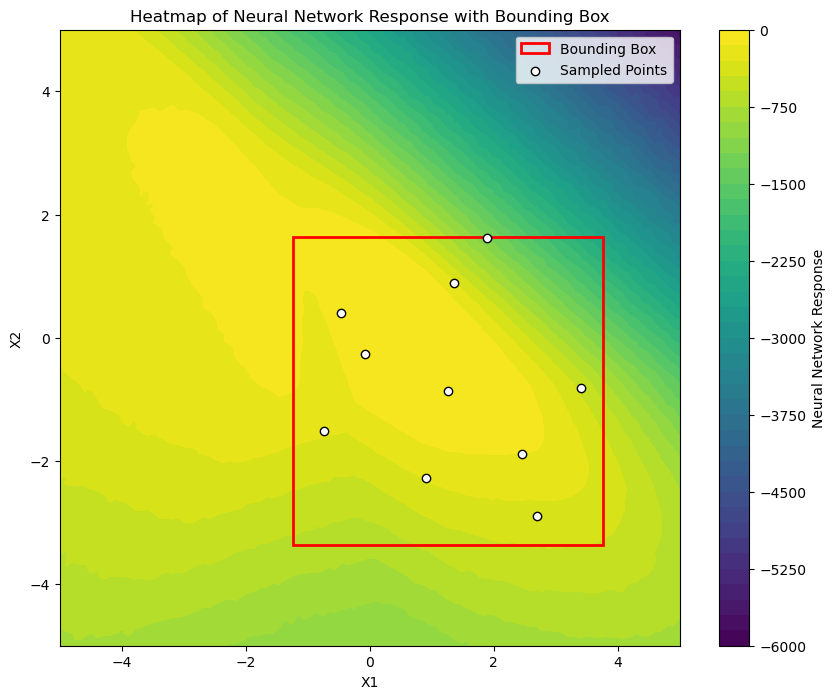

In [47]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.0030154921970662863
dropout_rate: 0.0
batch_size: 20
epochs: 120
Epoch 1/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 89555.0000
Epoch 2/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87387.3438 
Epoch 3/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33490.1289 
Epoch 4/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24253.7383 
Epoch 5/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25313.1758 
Epoch 6/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22962.0801 
Epoch 7/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19164.4258 
Epoch 8/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19288.6094 
Epoch 9/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13186.0186
Epoch 10/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16264.2988 
Epoch 11/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16781.2031 
Epoch 12/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17491.5879 
Epoch 13/120
3/3 ━━━━━━━━━━━━━━━━━━━━

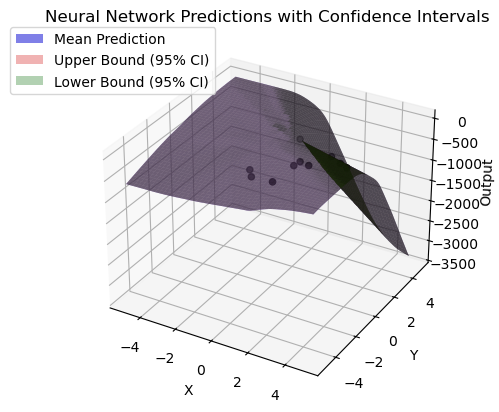

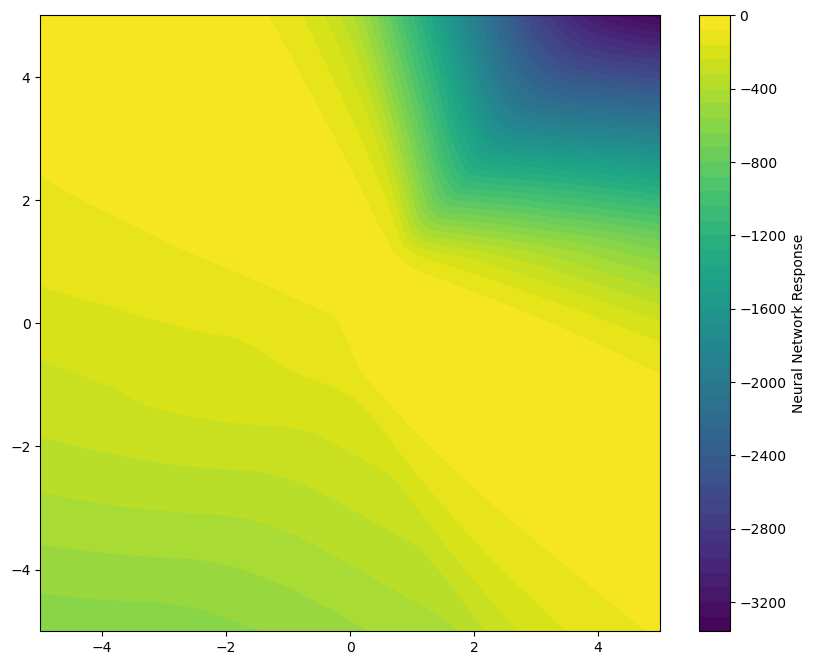

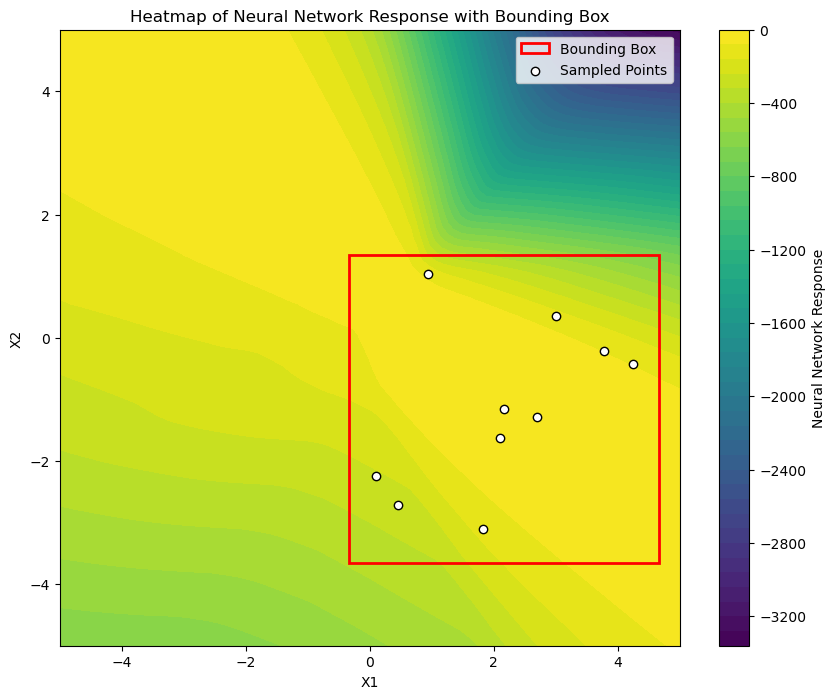

In [48]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 8
num_units: 200
learning_rate: 0.000750606498297241
dropout_rate: 0.0
batch_size: 29
epochs: 177
Epoch 1/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 85238.9766
Epoch 2/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 82462.0781 
Epoch 3/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82078.4141 
Epoch 4/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 82915.4688 
Epoch 5/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80212.3750 
Epoch 6/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79991.1953  
Epoch 7/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61667.3516 
Epoch 8/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46304.7812 
Epoch 9/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23528.0586 
Epoch 10/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34304.6328 
Epoch 11/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22277.1016 
Epoch 12/177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19432.2129 
Epoch 13/177
3/3 ━━━━━━━━━━━━━━━━━━━━

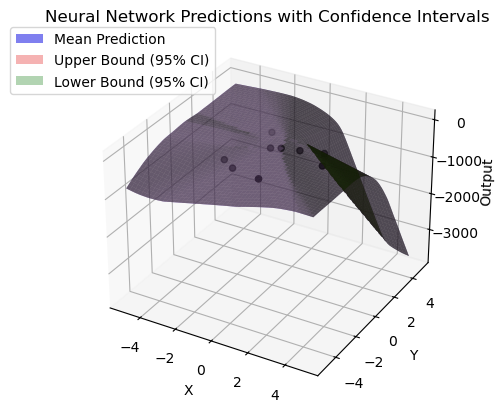

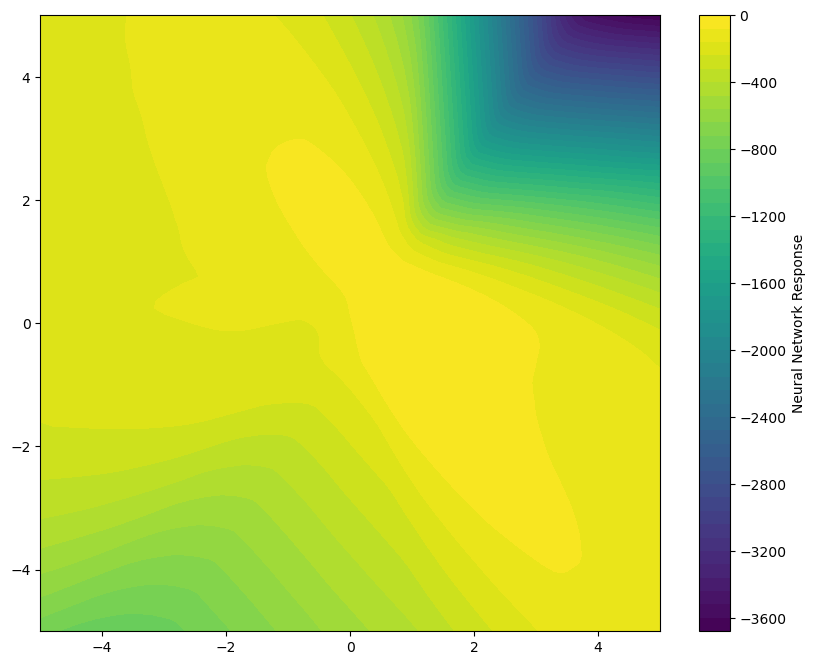

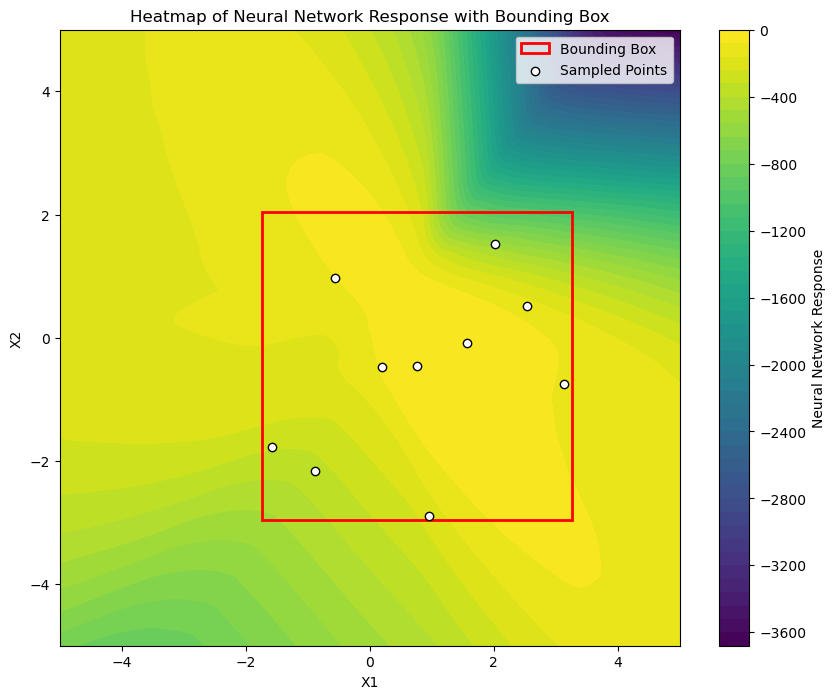

In [49]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 3
num_units: 195
learning_rate: 0.00409788855418806
dropout_rate: 0.08545479256802259
batch_size: 67
epochs: 163
Epoch 1/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 73751.6719
Epoch 2/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70280.5234 
Epoch 3/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72353.9219 
Epoch 4/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 68227.1406 
Epoch 5/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67490.1016 
Epoch 6/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63028.2812 
Epoch 7/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56734.4648 
Epoch 8/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44870.9453 
Epoch 9/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38853.1406 
Epoch 10/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28780.5605 
Epoch 11/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25359.4727 
Epoch 12/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23847.8223 
Epoch 13/163
2/2 ━━━━━━

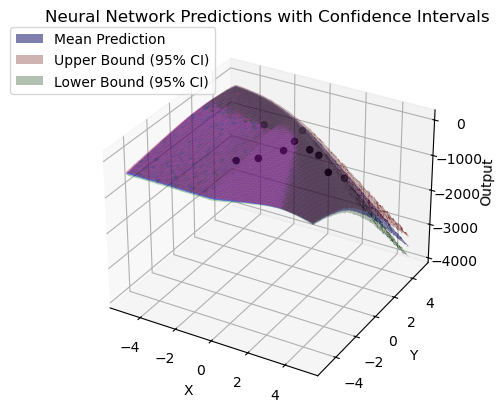

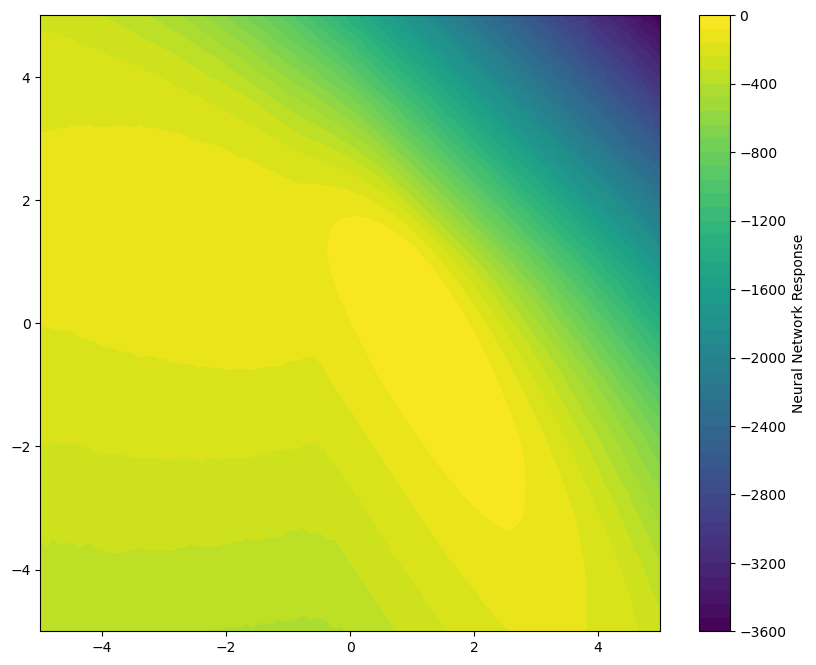

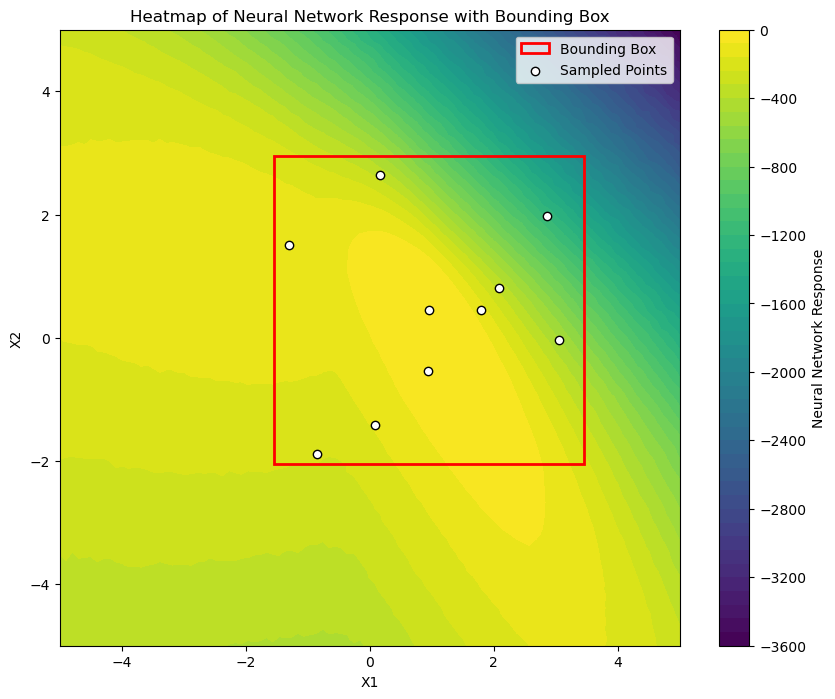

In [50]:
df_sim, df_new2 = perform_iteration(df_sim, df)

In [51]:
df_new2

x         y          z         a         b      sim_z      diff
2  2.863297  1.970284  -0.741798  4.258397 -3.109805  -0.503516 -0.238281
3  3.058288 -0.039340 -18.379372  4.258397 -3.109805 -18.262397 -0.116975
1  2.081919  0.814288 -52.312627  4.258397 -3.109805 -52.211776 -0.100851
5  0.170203  2.640378 -69.461306  4.258397 -3.109805 -69.409883 -0.051423
4  1.791867  0.447751 -78.954391  4.258397 -3.109805 -78.873934 -0.080457

In [52]:
df

x         y           z         a         b       sim_z      diff
0 -0.829780 -4.076614 -284.253932  4.258397 -3.109805 -284.189317 -0.064615
1  2.203245 -3.137398 -111.669530  4.258397 -3.109805 -111.883375  0.213845
2 -4.998856 -1.544393 -247.301416  4.258397 -3.109805 -246.968163 -0.333254
3 -1.976674 -1.032325 -128.722651  4.258397 -3.109805 -128.486903 -0.235748
4 -3.532441  0.388167 -111.174208  4.258397 -3.109805 -111.231325  0.057117
5  2.756950  1.583523   -6.166477  4.258397 -3.109805   -6.185117  0.018641
6  2.636728 -1.072043  -36.570571  4.258397 -3.109805  -36.626082  0.055512
7  1.846814  3.145949  -42.199184  4.258397 -3.109805  -42.101377 -0.097808
8  0.782525  2.527269  -61.903957  4.258397 -3.109805  -61.756762 -0.147195
9  1.037271  2.054459  -64.988641  4.258397 -3.109805  -64.896353 -0.092288

In [53]:
df = pd.concat([df, df_new2], ignore_index=True)
df

x         y           z         a         b       sim_z      diff
0  -0.829780 -4.076614 -284.253932  4.258397 -3.109805 -284.189317 -0.064615
1   2.203245 -3.137398 -111.669530  4.258397 -3.109805 -111.883375  0.213845
2  -4.998856 -1.544393 -247.301416  4.258397 -3.109805 -246.968163 -0.333254
3  -1.976674 -1.032325 -128.722651  4.258397 -3.109805 -128.486903 -0.235748
4  -3.532441  0.388167 -111.174208  4.258397 -3.109805 -111.231325  0.057117
5   2.756950  1.583523   -6.166477  4.258397 -3.109805   -6.185117  0.018641
6   2.636728 -1.072043  -36.570571  4.258397 -3.109805  -36.626082  0.055512
7   1.846814  3.145949  -42.199184  4.258397 -3.109805  -42.101377 -0.097808
8   0.782525  2.527269  -61.903957  4.258397 -3.109805  -61.756762 -0.147195
9   1.037271  2.054459  -64.988641  4.258397 -3.109805  -64.896353 -0.092288
10  2.863297  1.970284   -0.741798  4.258397 -3.109805   -0.503516 -0.238281
11  3.058288 -0.039340  -18.379372  4.258397 -3.109805  -18.262397 -0.116975
12  2.081919  0.814288  -52.312627  4.258397 -3.109805  -52.211776 -0.100851
13  0.170203  2.640378  -69.461306  4.258397 -3.109805  -69.409883 -0.051423
14  1.791867  0.447751  -78.954391  4.258397 -3.109805  -78.873934 -0.080457

In [54]:
df = df.iloc[:, :-4]
df

x         y           z
0  -0.829780 -4.076614 -284.253932
1   2.203245 -3.137398 -111.669530
2  -4.998856 -1.544393 -247.301416
3  -1.976674 -1.032325 -128.722651
4  -3.532441  0.388167 -111.174208
5   2.756950  1.583523   -6.166477
6   2.636728 -1.072043  -36.570571
7   1.846814  3.145949  -42.199184
8   0.782525  2.527269  -61.903957
9   1.037271  2.054459  -64.988641
10  2.863297  1.970284   -0.741798
11  3.058288 -0.039340  -18.379372
12  2.081919  0.814288  -52.312627
13  0.170203  2.640378  -69.461306
14  1.791867  0.447751  -78.954391

In [55]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.12560835 -3.16085289]


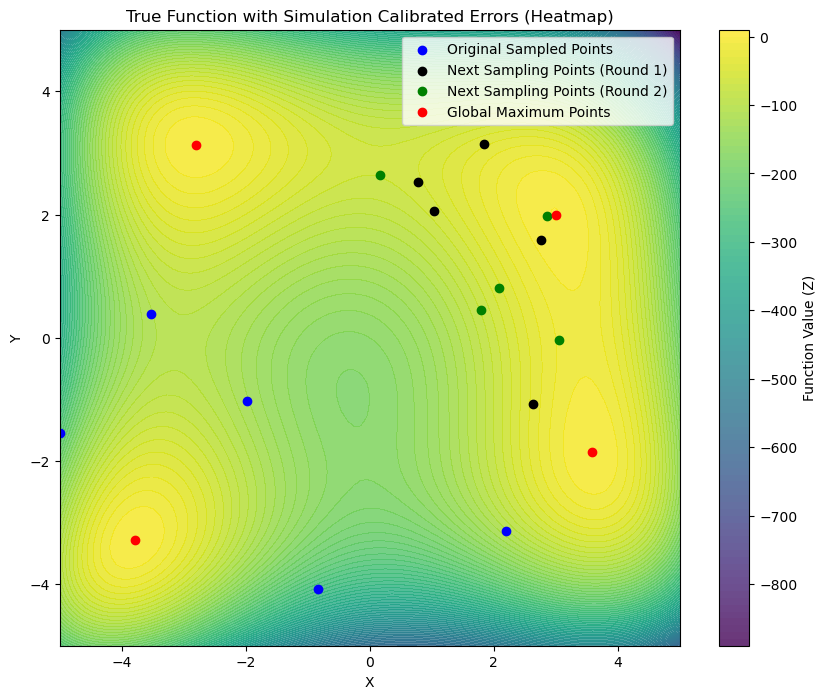

In [56]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [57]:
df

x         y           z         a         b       sim_z      diff
0  -0.829780 -4.076614 -284.253932  4.125608 -3.160853 -284.468240  0.214307
1   2.203245 -3.137398 -111.669530  4.125608 -3.160853 -111.898887  0.229357
2  -4.998856 -1.544393 -247.301416  4.125608 -3.160853 -247.243229 -0.058187
3  -1.976674 -1.032325 -128.722651  4.125608 -3.160853 -128.583913 -0.138737
4  -3.532441  0.388167 -111.174208  4.125608 -3.160853 -111.395220  0.221012
5   2.756950  1.583523   -6.166477  4.125608 -3.160853   -6.057763 -0.108713
6   2.636728 -1.072043  -36.570571  4.125608 -3.160853  -36.483888 -0.086683
7   1.846814  3.145949  -42.199184  4.125608 -3.160853  -42.136305 -0.062879
8   0.782525  2.527269  -61.903957  4.125608 -3.160853  -61.792628 -0.111329
9   1.037271  2.054459  -64.988641  4.125608 -3.160853  -64.885273 -0.103368
10  2.863297  1.970284   -0.741798  4.125608 -3.160853   -0.489497 -0.252301
11  3.058288 -0.039340  -18.379372  4.125608 -3.160853  -18.189771 -0.189601
12  2.081919  0.814288  -52.312627  4.125608 -3.160853  -52.163261 -0.149366
13  0.170203  2.640378  -69.461306  4.125608 -3.160853  -69.480521  0.019216
14  1.791867  0.447751  -78.954391  4.125608 -3.160853  -78.823123 -0.131268

In [58]:
# Assuming df is your DataFrame
average2 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -0.06257929721635964
